In [409]:
import numpy as np
from collections import namedtuple
from tqdm import tnrange, tqdm_notebook

LATTICE_SIZE = 10
N_CONFIGS_PER_SAMPLE = 10
N_STEPS_STABILIZE = 10000
N_STEPS_AVG = 1000

def create_random_config(N):
    """Create spin configuration of NxN lattice"""
    return 2 * np.random.randint(2, size=(N, N)) - 1

# better way:
# https://tanyaschlusser.github.io/posts/mcmc-and-the-ising-model/
def get_dH(lattice, location):
    """ H = - Sum_<ij>(s_i s_j) """
    i, j = location
    N, _ = lattice.shape
    H, Hflip = 0, 0
    for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        ii = (i + di) % N
        jj = (j + dj) % N
        H -= lattice[ii, jj] * lattice[i, j]
        Hflip += lattice[ii, jj] * lattice[i, j]
    return Hflip - H

def neighbours_sum(lattice, loc):
    i, j = loc
    N, _ = lattice.shape
    up = (i, (j-1)%N)
    left = ((i-1)%N, j)
    right = ((i+1)%N, j)
    down = (i, (j+1)%N)
    return lattice[up] + lattice[down] + lattice[left] + lattice[right]

def step(lattice, T):
    # Pick a random position in a lattice
    (N, _) = lattice.shape
    indices = np.random.randint(0, high=N, size=2)
    i, j = indices[0], indices[1]
    
    dH = get_dH(lattice, (i, j))
    
    maybe_flip(lattice, dH, (i, j), T)
    return lattice

def maybe_flip(lattice, dH, loc, T):
    i, j = loc
    
    if dH < 0:
        lattice[i,j] = -lattice[i,j]
    elif np.random.rand() < np.exp(-dH / T):
            lattice[i, j] = -lattice[i,j]
    return lattice

def energy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            entry = config[i,j]
            nb = neighbours_sum(config, (i, j))
            energy += -nb*entry
    return energy/4.


def mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag



In [410]:
Sample = namedtuple('Sample', ['energy_avg', 'energy_std', 'mag_avg', 'mag_std'])

def stabilize(config, T):
    for _ in range(N_STEPS_STABILIZE):
        step(config, T)    

def sample(T):
    """Obtain a single sample point for a given temperature"""
    energies = []
    mags = []

    for _ in tqdm_notebook(range(N_CONFIGS_PER_SAMPLE), leave=False):
        
        config = create_random_config(N=LATTICE_SIZE)
        
        stabilize(config, T)
        
        for _ in tqdm_notebook(range(N_STEPS_AVG), leave=False):
            step(config, T)
            energies.append(energy(config))
            mags.append(mag(config))

    return Sample(energy_avg=np.mean(energies), energy_std=np.std(energies),
                  mag_std=np.std(mags), mag_avg=np.mean(mags))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

temps = np.linspace(0.1, 9.0, num=15)

samples = []
for t in tqdm_notebook(temps):
    samples.append(sample(t))
    
energy_avgs = [s.energy_avg for s in samples]
energy_stds   = [s.energy_std  for s in samples]
mag_avgs    = [s.mag_avg    for s in samples]
mag_stds      = [s.mag_std     for s in samples]

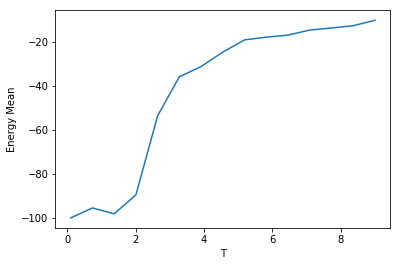

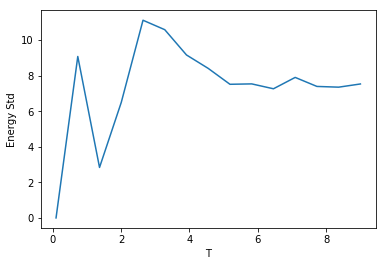

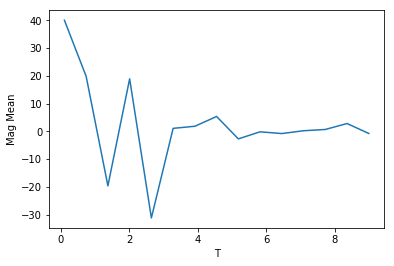

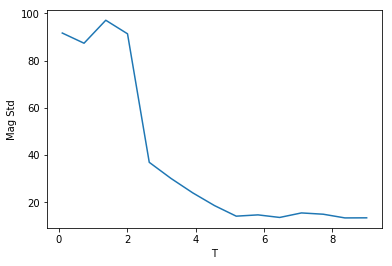

In [414]:
plt.plot(temps, energy_avgs)
plt.ylabel('Energy Mean')
plt.xlabel('T')
plt.show()

plt.plot(temps, energy_stds)
plt.ylabel('Energy Std')
plt.xlabel('T')
plt.show()

plt.plot(temps, mag_avgs)
plt.xlabel('T')
plt.ylabel('Mag Mean')
plt.show()

plt.plot(temps, mag_stds)
plt.ylabel('Mag Std')
plt.xlabel('T')
plt.show()

In [381]:
np.mean([1,2,3])

2.0